In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-11aebd04-b7fe-0a13-b18f-52e41c901956)


In [ ]:
!pip install pythainlp
!pip install epitran
!pip install sklearn_crfsuite
!pip install tensorflow deepcut
!pip install attacut

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.5 MB 6.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 161 kB 8.2 MB/s 
     |████████████████████████████████| 73 kB 2.5 MB/s 
     |████████████████████████████████| 1.2 MB 72.7 MB/s 
  Created wheel for unicodecsv: filename=unicodecsv-0.14.1-py3-none-any.whl size=10768 sha256=85a9c5b05b0308350458b0a7fd27014425c68bc2aef74e68326d41ef02b5fb84
  Stored in directory: /root/.cache/pip/wheels/1a/f4/8a/a5024fb77b32ed369e5c409081e5f00fbe3b92fdad653f6e69
Successfully built unicodecsv
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 965 kB 8.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████

In [ ]:
!wget -q http://www.arts.chula.ac.th/ling/wp-content/uploads/TH-Sarabun_Chula1.1.zip -O font.zip
!unzip -qj font.zip TH-Sarabun_Chula1.1/THSarabunChula-Regular.ttf

In [ ]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import collections
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.vgg16 import VGG16, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import cv2

from imutils import paths

import matplotlib as mpl

import pythainlp
from pythainlp import sent_tokenize, word_tokenize

np.random.seed(1234)

tf.random.set_seed(5678)

In [ ]:
mpl.font_manager.fontManager.addfont('THSarabunChula-Regular.ttf')
mpl.rc('font', family='TH Sarabun Chula', size=20)

In [ ]:
!git clone https://github.com/manadda-j/BADS7604.git

Cloning into 'BADS7604'...
remote: Enumerating objects: 6286, done.
remote: Counting objects: 100% (742/742), done.
remote: Compressing objects: 100% (742/742), done.
remote: Total 6286 (delta 0), reused 740 (delta 0), pack-reused 5544
Receiving objects: 100% (6286/6286), 4.25 GiB | 38.85 MiB/s, done.
Resolving deltas: 100% (175/175), done.
Checking out files: 100% (5767/5767), done.


Import Data

In [ ]:
data_dir = '/content/BADS7604/04ImageCaptioning/Dataset'

image_name = []
caption = []
image_path = []
dataset = []
caption_tokenize = []

imagePaths = sorted(list(paths.list_images(data_dir)))

np.random.seed(77)
np.random.shuffle(imagePaths)


for imagePath in imagePaths:
    #img path
    image_path.append(imagePath)

    #get the image name
    name = imagePath.split("/")[-1]
    image_name.append(name)

    # extract label from the image path and update the labels list
    label = imagePath.split("/")[-3]
    caption.append(label)

    img_set = imagePath.split("/")[-2]
    dataset.append(img_set)

    label_tokenize = word_tokenize(label, engine='deepcut')
    caption_tokenize.append(label_tokenize)

In [ ]:
dataset = {'ImageName':image_name, 'Caption':caption, 'Path':image_path, 'Set':dataset, 'Caption_tokenize': caption_tokenize}
data_df = pd.DataFrame(dataset)
data_df['Caption_tokenize_final'] = data_df['Caption_tokenize'].apply(lambda x: ' '.join(x))

data_df.head()

,ImageName,Caption,Path,Set,Caption_tokenize,Caption_tokenize_final
0,_0_684(1).jpeg,ติดตั้งนอตยึดบานพับให้เรียบร้อย,/content/BADS7604/04ImageCaptioning/Dataset/ติ...,test,"[ติดตั้ง, นอต, ยึด, บาน, พับ, ให้, เรียบร้อย]",ติดตั้ง นอต ยึด บาน พับ ให้ เรียบร้อย
1,_0_4448.jpeg,ทำความสะอาดแอร์ให้เรียบร้อย,/content/BADS7604/04ImageCaptioning/Dataset/ทำ...,train,"[ทำ, ความ, สะอาด, แอร์, ให้, เรียบร้อย]",ทำ ความ สะอาด แอร์ ให้ เรียบร้อย
2,IMG_3874.JPG,เก็บสีโครงเหล็กให้เรียบร้อย,/content/BADS7604/04ImageCaptioning/Dataset/เก...,train,"[เก็บ, สี, โครงเหล็ก, ให้, เรียบร้อย]",เก็บ สี โครงเหล็ก ให้ เรียบร้อย
3,Pave_180911_0070.jpg,เก็บสีโครงเหล็กให้เรียบร้อย,/content/BADS7604/04ImageCaptioning/Dataset/เก...,test,"[เก็บ, สี, โครงเหล็ก, ให้, เรียบร้อย]",เก็บ สี โครงเหล็ก ให้ เรียบร้อย
4,_0_2048.jpeg,แก้ไขปลั๊กสวิตช์เอียง,/content/BADS7604/04ImageCaptioning/Dataset/แก...,train,"[แก้ไข, ปลั๊ก, สวิตช์, เอียง]",แก้ไข ปลั๊ก สวิตช์ เอียง


In [ ]:
data_df[data_df['Set']=='train'].groupby(['Caption']).agg({'ImageName': ['count']})

,ImageName
,count
Caption,
ขัดแต่งผนังและเก็บสีให้เรียบร้อย,176
ขัดแต่งฝ้าและเก็บสีให้เรียบร้อย,160
จับเซี้ยมรอบช่องเปิดพร้อมเก็บสีให้เรียบร้อย,126
ติดตั้งนอตยึดบานพับให้เรียบร้อย,110
ทำความสะอาดถังบำบัดน้ำเสีย,154
ทำความสะอาดลูกบิด,162
ทำความสะอาดแอร์ให้เรียบร้อย,108
เก็บยาแนวกระเบื้องให้เรียบร้อย,160


In [ ]:
captions = list(data_df['Caption'].value_counts().index)
values = list(data_df['Caption'].value_counts().values)

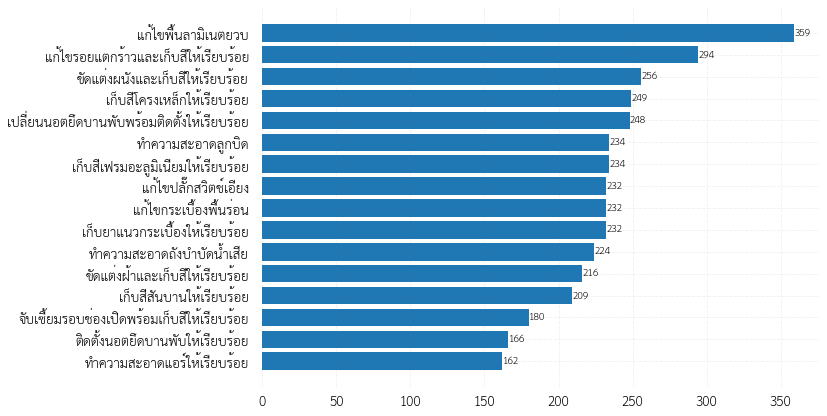

In [ ]:
fig, ax = plt.subplots(figsize =(10, 7))

plt.rcParams['font.size'] = '16'
 
# Horizontal Bar Plot
ax.barh(captions, values)
 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
 
# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)
 
# Add x, y gridlines
ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
# Show top values
ax.invert_yaxis()
 
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 15, fontweight ='bold',
             )
 
  
# Show Plot
plt.show()

In [ ]:
data_df['Caption_tokenize_final'].astype('str').value_counts()

แก้ไข พื้น ลามิเนตยวบ                                  359
แก้ไข รอย แตกร้าว และ เก็บ สี ให้ เรียบร้อย            294
ขัดแต่ง ผนัง และ เก็บ สี ให้ เรียบร้อย                 256
เก็บ สี โครงเหล็ก ให้ เรียบร้อย                        249
เปลี่ยน นอต ยึด บาน พับ พร้อม ติดตั้ง ให้ เรียบร้อย    248
ทำ ความ สะอาด ลูกบิด                                   234
เก็บ สี เฟรม อะลูมิเนียม ให้ เรียบร้อย                 234
แก้ไข ปลั๊ก สวิตช์ เอียง                               232
แก้ไข กระเบื้อง พื้น ร่อน                              232
เก็บ ยา แนว กระเบื้อง ให้ เรียบร้อย                    232
ทำ ความ สะอาด ถัง บำบัด น้ำ เสีย                       224
ขัด แต่ง ฝ้า และ เก็บ สี ให้ เรียบร้อย                 216
เก็บ สี สัน บาน ให้ เรียบร้อย                          209
จับเซี้ยม รอบ ช่อง เปิด พร้อม เก็บ สี ให้ เรียบร้อย    180
ติดตั้ง นอต ยึด บาน พับ ให้ เรียบร้อย                  166
ทำ ความ สะอาด แอร์ ให้ เรียบร้อย                       162
Name: Caption_tokenize_final, dtype: int64

Train

In [ ]:
df_train = data_df[(data_df['Set']=='train')]
img_path_train = list(df_train['Path'])

In [ ]:
df_train.shape

(2617, 6)

In [ ]:
## Vocabulary Size 
## unique word in caption
vocabulary = []
for txt in df_train.Caption_tokenize_final.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 46


In [ ]:
all_captions = []
for caption  in df_train["Caption_tokenize_final"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:5]

['<start> ทำ ความ สะอาด แอร์ ให้ เรียบร้อย <end>',
 '<start> เก็บ สี โครงเหล็ก ให้ เรียบร้อย <end>',
 '<start> แก้ไข ปลั๊ก สวิตช์ เอียง <end>',
 '<start> เปลี่ยน นอต ยึด บาน พับ พร้อม ติดตั้ง ให้ เรียบร้อย <end>',
 '<start> ขัดแต่ง ผนัง และ เก็บ สี ให้ เรียบร้อย <end>']

In [ ]:
def calc_max_length(caption):
   return max([len(c.split(' ')) for c in caption])

max_length = calc_max_length(all_captions)

def calc_min_length(caption):
   return min([len(c.split(' ')) for c in caption])

min_length = calc_min_length(all_captions)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 11 : 5


In [ ]:
def data_limiter(num,total_captions,all_img_name_vector):
  train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
  train_captions = train_captions[:num]
  img_name_vector = img_name_vector[:num]
  return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(10000,all_captions,img_path_train)
print(f"len(train_captions) : {len(train_captions)}")
print(f"len(img_name_vector) : {len(img_name_vector)}")

len(train_captions) : 2617
len(img_name_vector) : 2617


In [ ]:
img_name_vector[40]

'/content/BADS7604/04ImageCaptioning/Dataset/แก้ไขปลั๊กสวิตช์เอียง/train/IMG20210620160450.jpg'

In [ ]:
def plt_imshow(img_file):
  image = cv2.imread(img_file)
	# convert the image frame BGR to RGB color space and display it
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  plt.figure(figsize=(10,10))
  plt.imshow(image)
  plt.grid(False)
  plt.show()

<start> ติดตั้ง นอต ยึด บาน พับ ให้ เรียบร้อย <end>


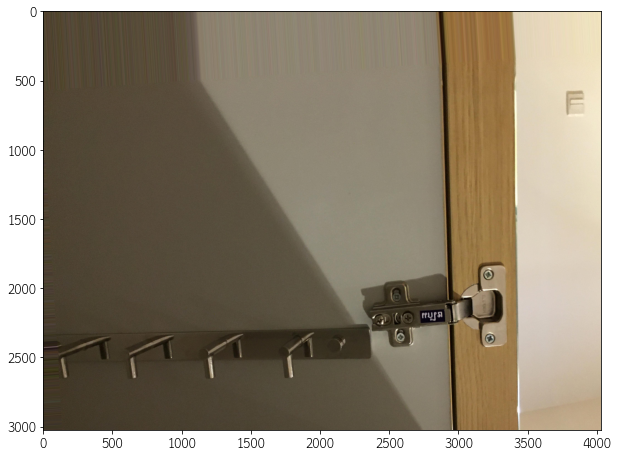

In [ ]:
print(train_captions[151])
plt_imshow(img_name_vector[151])

In [ ]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = tf.keras.applications.vgg16.preprocess_input(img)
   return img, image_path

In [ ]:
image_model = tf.keras.applications.vgg16.VGG16(include_top=False,
                                                weights='imagenet')
image_model.trainable = False
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
image_features_extract_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [ ]:
# Get unique images
encode_train = sorted(set(img_name_vector))

image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
    load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

In [ ]:
%%time
for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

CPU times: user 2min 36s, sys: 5.03 s, total: 2min 41s
Wall time: 1min 42s


Preprocess and tokenize the captions

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 11
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
cap_vector

<MapDataset element_spec=TensorSpec(shape=(None,), dtype=tf.int64, name=None)>

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
index_to_word

Prepare training data

In [ ]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

img_name_train = []
cap_train = []
for img in img_to_cap_vector:
  capt_len = len(img_to_cap_vector[img])
  img_name_train.extend([img] * capt_len)
  cap_train.extend(img_to_cap_vector[img])

In [ ]:
img_name_train[:5]

['/content/BADS7604/04ImageCaptioning/Dataset/เปลี่ยนนอตยึดบานพับพร้อมติดตั้งให้เรียบร้อย/train/_0_6618.jpeg',
 '/content/BADS7604/04ImageCaptioning/Dataset/แก้ไขปลั๊กสวิตช์เอียง/train/_0_7409.jpeg',
 '/content/BADS7604/04ImageCaptioning/Dataset/เปลี่ยนนอตยึดบานพับพร้อมติดตั้งให้เรียบร้อย/train/_0_832.jpeg',
 '/content/BADS7604/04ImageCaptioning/Dataset/แก้ไขปลั๊กสวิตช์เอียง/train/_0_6676.jpeg',
 '/content/BADS7604/04ImageCaptioning/Dataset/ทำความสะอาดถังบำบัดน้ำเสีย/train/_0_6694.jpeg']

In [ ]:
cap_train[:5]

[<tf.Tensor: shape=(11,), dtype=int64, numpy=array([ 2, 27, 19, 17, 10, 18, 16, 20,  4,  5,  3])>,
 <tf.Tensor: shape=(11,), dtype=int64, numpy=array([ 2,  8, 38, 35, 34,  3,  0,  0,  0,  0,  0])>,
 <tf.Tensor: shape=(11,), dtype=int64, numpy=array([ 2, 27, 19, 17, 10, 18, 16, 20,  4,  5,  3])>,
 <tf.Tensor: shape=(11,), dtype=int64, numpy=array([ 2,  8, 38, 35, 34,  3,  0,  0,  0,  0,  0])>,
 <tf.Tensor: shape=(11,), dtype=int64, numpy=array([ 2, 12, 13, 11, 43, 41, 42, 40,  3,  0,  0])>]

In [ ]:
len(img_name_train), len(cap_train)

(2617, 2617)

Create a tf.data dataset for training

In [ ]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 16
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 512
attention_features_shape = 49

In [ ]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int64]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

Model

In [ ]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [ ]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [ ]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [ ]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, tokenizer.vocabulary_size())

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

Checkpoint

In [ ]:
checkpoint_path = "/content/drive/MyDrive/BADS7604 Deep Learning/Project/model/checkpoint_vgg"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

Training

In [ ]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [ ]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([word_to_index('<start>')] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
EPOCHS = 30

times = []
train_loss = []


for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)
    train_loss.append(f'{total_loss/num_steps:.6f}')

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

    times.append(time.time()-start)

Epoch 1 Batch 0 Loss 2.4037
Epoch 1 Batch 100 Loss 0.2042
Epoch 1 Loss 0.790832
Time taken for 1 epoch 25.22 sec

Epoch 2 Batch 0 Loss 0.1297
Epoch 2 Batch 100 Loss 0.1208
Epoch 2 Loss 0.073652
Time taken for 1 epoch 3.71 sec

Epoch 3 Batch 0 Loss 0.0560
Epoch 3 Batch 100 Loss 0.0255
Epoch 3 Loss 0.029584
Time taken for 1 epoch 3.67 sec

Epoch 4 Batch 0 Loss 0.0091
Epoch 4 Batch 100 Loss 0.0054
Epoch 4 Loss 0.015888
Time taken for 1 epoch 3.67 sec

Epoch 5 Batch 0 Loss 0.0150
Epoch 5 Batch 100 Loss 0.0155
Epoch 5 Loss 0.018311
Time taken for 1 epoch 3.62 sec

Epoch 6 Batch 0 Loss 0.0236
Epoch 6 Batch 100 Loss 0.0046
Epoch 6 Loss 0.010276
Time taken for 1 epoch 3.81 sec

Epoch 7 Batch 0 Loss 0.0428
Epoch 7 Batch 100 Loss 0.0187
Epoch 7 Loss 0.015065
Time taken for 1 epoch 3.60 sec

Epoch 8 Batch 0 Loss 0.0027
Epoch 8 Batch 100 Loss 0.0039
Epoch 8 Loss 0.006650
Time taken for 1 epoch 3.60 sec

Epoch 9 Batch 0 Loss 0.0007
Epoch 9 Batch 100 Loss 0.0017
Epoch 9 Loss 0.008605
Time taken for 

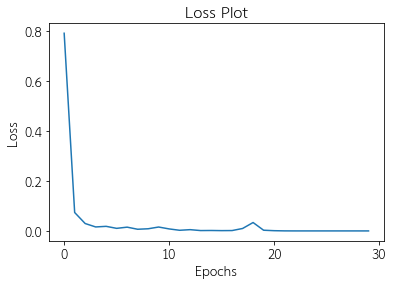

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
inceptionV3_train = {'Loss':train_loss, 'Time': times}
inceptionV3_train_df = pd.DataFrame(inceptionV3_train)
inceptionV3_train_df.to_csv('vgg16_result.csv')

Caption

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([word_to_index('<start>')], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [ ]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(int(np.ceil(len_result/2)), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [ ]:
df_test = data_df[(data_df['Set']=='test')]
df_test.head()

,ImageName,Caption,Path,Set,Caption_tokenize,Caption_tokenize_final
0,_0_684(1).jpeg,ติดตั้งนอตยึดบานพับให้เรียบร้อย,/content/BADS7604/04ImageCaptioning/Dataset/ติ...,test,"[ติดตั้ง, นอต, ยึด, บาน, พับ, ให้, เรียบร้อย]",ติดตั้ง นอต ยึด บาน พับ ให้ เรียบร้อย
3,Pave_180911_0070.jpg,เก็บสีโครงเหล็กให้เรียบร้อย,/content/BADS7604/04ImageCaptioning/Dataset/เก...,test,"[เก็บ, สี, โครงเหล็ก, ให้, เรียบร้อย]",เก็บ สี โครงเหล็ก ให้ เรียบร้อย
6,_0_9068.jpeg,แก้ไขรอยแตกร้าวและเก็บสีให้เรียบร้อย,/content/BADS7604/04ImageCaptioning/Dataset/แก...,test,"[แก้ไข, รอย, แตกร้าว, และ, เก็บ, สี, ให้, เรีย...",แก้ไข รอย แตกร้าว และ เก็บ สี ให้ เรียบร้อย
10,_0_9929.jpeg,แก้ไขปลั๊กสวิตช์เอียง,/content/BADS7604/04ImageCaptioning/Dataset/แก...,test,"[แก้ไข, ปลั๊ก, สวิตช์, เอียง]",แก้ไข ปลั๊ก สวิตช์ เอียง
14,_0_5855.jpeg,แก้ไขปลั๊กสวิตช์เอียง,/content/BADS7604/04ImageCaptioning/Dataset/แก...,test,"[แก้ไข, ปลั๊ก, สวิตช์, เอียง]",แก้ไข ปลั๊ก สวิตช์ เอียง


In [ ]:
df_test.shape

(1110, 6)

Real Caption: แก้ไข ปลั๊ก สวิตช์ เอียง
Prediction Caption: แก้ไข ปลั๊ก สวิตช์ เอียง


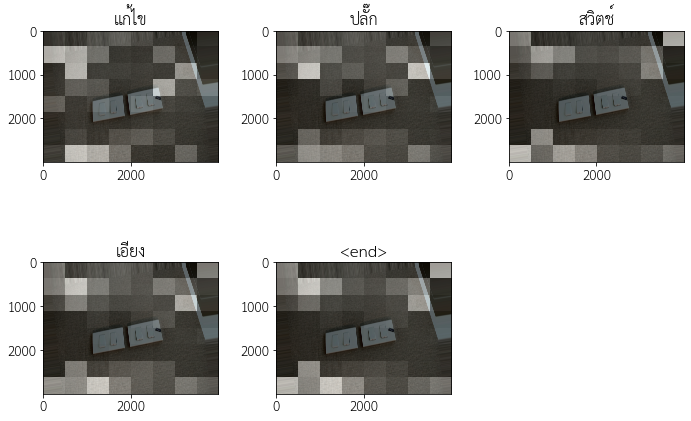

Real Caption: ขัด แต่ง ฝ้า และ เก็บ สี ให้ เรียบร้อย
Prediction Caption: ขัด แต่ง ฝ้า และ เก็บ สี ให้ เรียบร้อย


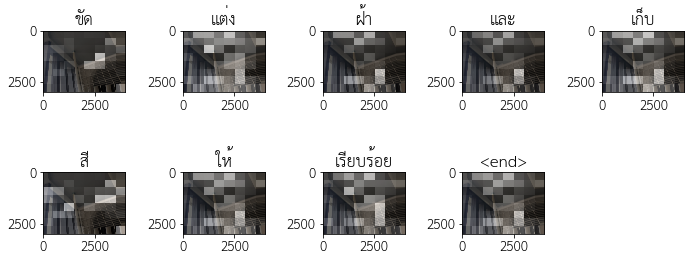

Real Caption: แก้ไข ปลั๊ก สวิตช์ เอียง
Prediction Caption: แก้ไข ปลั๊ก สวิตช์ เอียง


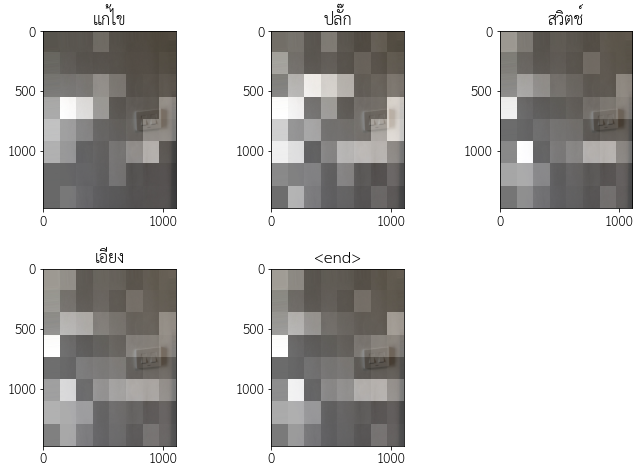

Real Caption: ขัดแต่ง ผนัง และ เก็บ สี ให้ เรียบร้อย
Prediction Caption: ขัดแต่ง ผนัง และ เก็บ สี ให้ เรียบร้อย


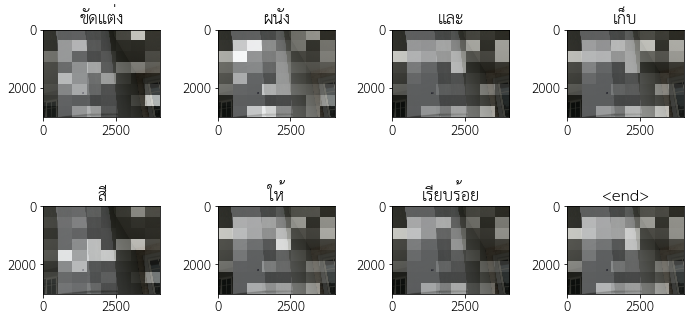

Real Caption: เก็บ สี เฟรม อะลูมิเนียม ให้ เรียบร้อย
Prediction Caption: เก็บ สี เฟรม อะลูมิเนียม ให้ เรียบร้อย


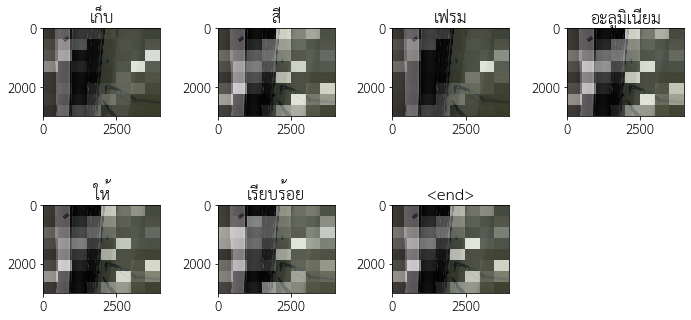

Real Caption: ทำ ความ สะอาด แอร์ ให้ เรียบร้อย
Prediction Caption: ทำ ความ สะอาด แอร์ ให้ เรียบร้อย


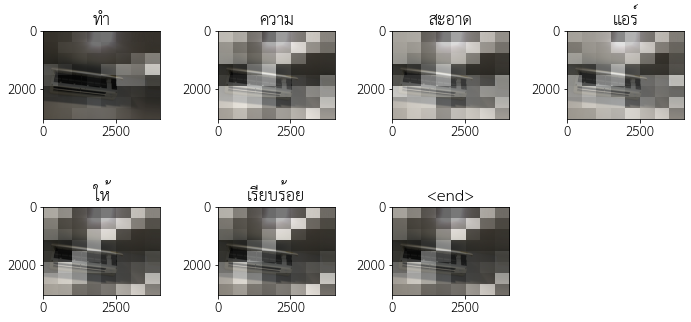

Real Caption: เก็บ ยา แนว กระเบื้อง ให้ เรียบร้อย
Prediction Caption: เก็บ ยา แนว กระเบื้อง ให้ เรียบร้อย


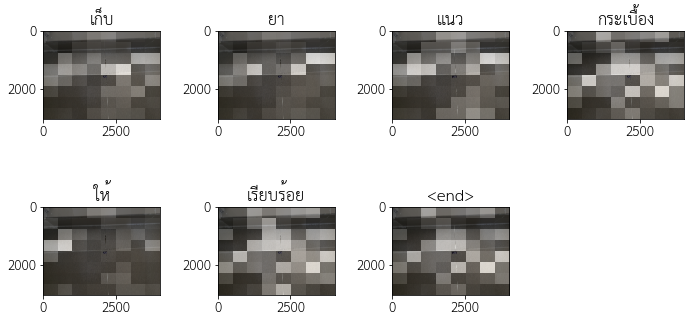

Real Caption: แก้ไข กระเบื้อง พื้น ร่อน
Prediction Caption: แก้ไข รอย แตกร้าว และ เก็บ สี ให้ เรียบร้อย


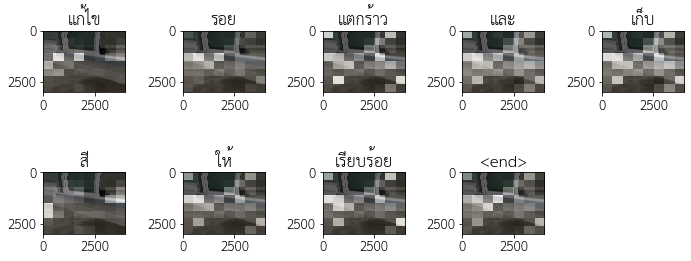

Real Caption: เก็บ ยา แนว กระเบื้อง ให้ เรียบร้อย
Prediction Caption: เก็บ ยา แนว กระเบื้อง ให้ เรียบร้อย


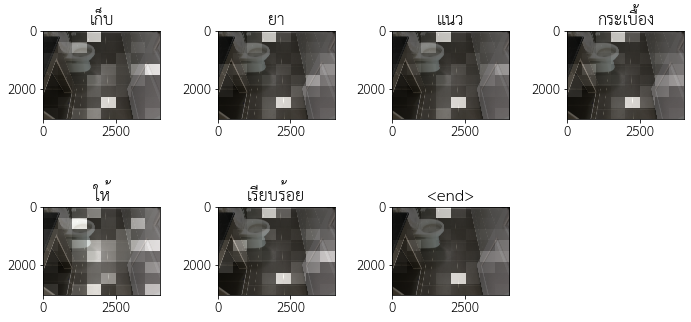

Real Caption: แก้ไข ปลั๊ก สวิตช์ เอียง
Prediction Caption: แก้ไข ปลั๊ก สวิตช์ เอียง


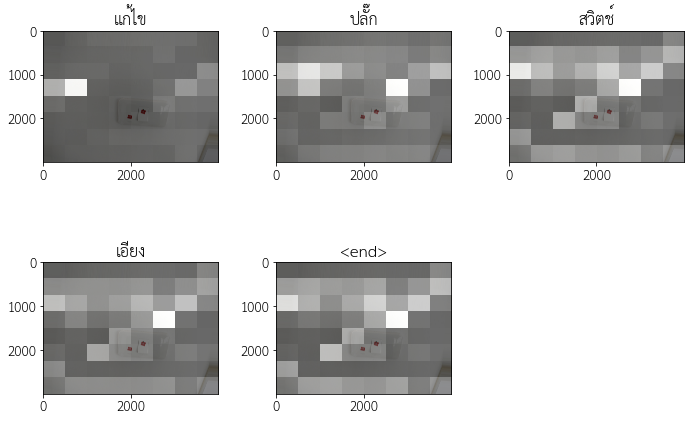

In [ ]:
# captions on the validation set
for i in range(10):
  rid = np.random.randint(0, len(df_test))
  image = df_test['Path'].iloc[rid]

  real_caption = df_test['Caption_tokenize_final'].iloc[rid]
  result, attention_plot = evaluate(image)
  final_result = result[:-1]

  print('Real Caption:', real_caption)
  print('Prediction Caption:', ' '.join(final_result))
  plot_attention(image, result, attention_plot)

In [ ]:
import sys
import codecs
import os
import math
import operator
import json
from functools import reduce


def count_ngram(candidate, references, n):
    clipped_count = 0
    count = 0
    r = 0
    c = 0
    for si in range(len(candidate)):
        # Calculate precision for each sentence
        ref_counts = []
        ref_lengths = []
        # Build dictionary of ngram counts
        for reference in references:
            ref_sentence = reference[si]
            ngram_d = {}
            words = ref_sentence.strip().split()
            ref_lengths.append(len(words))
            limits = len(words) - n + 1
            # loop through the sentance consider the ngram length
            for i in range(limits):
                ngram = ' '.join(words[i:i+n]).lower()
                if ngram in ngram_d.keys():
                    ngram_d[ngram] += 1
                else:
                    ngram_d[ngram] = 1
            ref_counts.append(ngram_d)
        # candidate
        cand_sentence = candidate[si]
        cand_dict = {}
        words = cand_sentence.strip().split()
        limits = len(words) - n + 1
        for i in range(0, limits):
            ngram = ' '.join(words[i:i + n]).lower()
            if ngram in cand_dict:
                cand_dict[ngram] += 1
            else:
                cand_dict[ngram] = 1
        clipped_count += clip_count(cand_dict, ref_counts)
        count += limits
        r += best_length_match(ref_lengths, len(words))
        c += len(words)
    if clipped_count == 0:
        pr = 0
    else:
        pr = float(clipped_count) / count
    bp = brevity_penalty(c, r)
    return pr, bp


def clip_count(cand_d, ref_ds):
    """Count the clip count for each ngram considering all references"""
    count = 0
    for m in cand_d.keys():
        m_w = cand_d[m]
        m_max = 0
        for ref in ref_ds:
            if m in ref:
                m_max = max(m_max, ref[m])
        m_w = min(m_w, m_max)
        count += m_w
    return count


def best_length_match(ref_l, cand_l):
    """Find the closest length of reference to that of candidate"""
    least_diff = abs(cand_l-ref_l[0])
    best = ref_l[0]
    for ref in ref_l:
        if abs(cand_l-ref) < least_diff:
            least_diff = abs(cand_l-ref)
            best = ref
    return best


def brevity_penalty(c, r):
    if c > r:
        bp = 1
    else:
        bp = math.exp(1-(float(r)/c))
    return bp


def geometric_mean(precisions):
    return (reduce(operator.mul, precisions)) ** (1.0 / len(precisions))


def BLEU_ngram(candidate, references, ngram):
  precisions = []
  for i in range(ngram):
    pr, bp = count_ngram(candidate, references, i+1)
    precisions.append(pr)
  bleu = geometric_mean(precisions) * bp
  return bleu

# def BLEU(candidate, references):
#     precisions = []
#     for i in range(4):
#         pr, bp = count_ngram(candidate, references, i+1)
#         precisions.append(pr)
#     bleu = geometric_mean(precisions) * bp
#     return bleu, precisions

In [ ]:
# total_score = []
BLEU_1 =[]
BLEU_2 =[]
BLEU_3 =[]
BLEU_4 =[]
img_class = []
real_captions = []
predict_captions = []
img_name = []

for i, data in df_test.iterrows():
  # print(data['Path'],data['Caption_tokenize_final'])
  # captions on the validation set
  # rid = np.random.randint(0, len(df_test))
  image = data['Path']

  # real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
  result, attention_plot = evaluate(image)

  # remove <start> and <end> from the real_caption
  # first = real_caption.split(' ', 1)[1]
  real_caption = data['Caption_tokenize_final']

  #remove "<unk>" in result
  for i in result:
    if i=="<unk>":
        result.remove(i)

  for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

  #remove <end> from result        
  result_join = ' '.join(result)
  result_final = result_join.rsplit(' ', 1)[0]

  real_appn = []
  real_appn.append([real_caption])
  reference = real_appn
  candidate = [result_final]
  print('reference', reference)
  print('candidate', candidate)
  # score_bleu = sentence_bleu(reference, candidate)
  score_bleu1 = BLEU_ngram(candidate, reference, 1)
  score_bleu2 = BLEU_ngram(candidate, reference, 2)
  score_bleu3 = BLEU_ngram(candidate, reference, 3)
  score_bleu4 = BLEU_ngram(candidate, reference, 4)
  # print(f"BELU score: {score_bleu*100}")
  print(f"BELU1 score: {score_bleu1*100}")
  print(f"BELU2 score: {score_bleu2*100}")
  print(f"BELU3 score: {score_bleu3*100}")
  print(f"BELU4 score: {score_bleu4*100}")

  # total_score.append(score_bleu)
  BLEU_1.append(score_bleu1*100)
  BLEU_2.append(score_bleu2*100)
  BLEU_3.append(score_bleu3*100)
  BLEU_4.append(score_bleu4*100)
  img_class.append(data['Caption'])
  real_captions.append(real_caption)
  predict_captions.append(result_final)
  img_name.append(data['ImageName'])

  print ('Real Caption:', real_caption)
  print ('Prediction Caption:', result_final)
  # plot_attention(image, result, attention_plot)
  # Image.open(image)

เอาต์พุตของการสตรีมมีการตัดเหลือเพียง 5000 บรรทัดสุดท้าย
reference [['ทำ ความ สะอาด ลูกบิด']]
candidate ['ทำ ความ สะอาด ลูกบิด']
BELU1 score: 100.0
BELU2 score: 100.0
BELU3 score: 100.0
BELU4 score: 100.0
Real Caption: ทำ ความ สะอาด ลูกบิด
Prediction Caption: ทำ ความ สะอาด ลูกบิด
reference [['แก้ไข ปลั๊ก สวิตช์ เอียง']]
candidate ['แก้ไข ปลั๊ก สวิตช์ เอียง']
BELU1 score: 100.0
BELU2 score: 100.0
BELU3 score: 100.0
BELU4 score: 100.0
Real Caption: แก้ไข ปลั๊ก สวิตช์ เอียง
Prediction Caption: แก้ไข ปลั๊ก สวิตช์ เอียง
reference [['แก้ไข พื้น ลามิเนตยวบ']]
candidate ['แก้ไข พื้น ลามิเนตยวบ']
BELU1 score: 100.0
BELU2 score: 100.0
BELU3 score: 100.0
BELU4 score: 0.0
Real Caption: แก้ไข พื้น ลามิเนตยวบ
Prediction Caption: แก้ไข พื้น ลามิเนตยวบ
reference [['เปลี่ยน นอต ยึด บาน พับ พร้อม ติดตั้ง ให้ เรียบร้อย']]
candidate ['เปลี่ยน นอต ยึด บาน พับ พร้อม ติดตั้ง ให้ เรียบร้อย']
BELU1 score: 100.0
BELU2 score: 100.0
BELU3 score: 100.0
BELU4 score: 100.0
Real Caption: เปลี่ยน นอต ยึด บาน พับ พร้อม

In [ ]:
# image_pred = {'Name':img_name, 'BLEU':total_score, 'BLEU1':BLEU_1 , 'BLEU2':BLEU_2, 'BLEU3':BLEU_3, 'BLEU4':BLEU_4,'Caption':real_captions, 'Pred':predict_captions}

image_pred = {'Name':img_name, 'BLEU1':BLEU_1 , 'BLEU2':BLEU_2, 'BLEU3':BLEU_3, 'BLEU4':BLEU_4,'Caption':real_captions, 'Pred':predict_captions}
image_pred_df = pd.DataFrame(image_pred)

In [ ]:
image_pred_df.head()

,Name,BLEU1,BLEU2,BLEU3,BLEU4,Caption,Pred
0,_0_684(1).jpeg,77.777778,69.721669,59.281555,51.334505,ติดตั้ง นอต ยึด บาน พับ ให้ เรียบร้อย,ติดตั้ง นอต ยึด บาน พับ พร้อม ติดตั้ง ให้ เรีย...
1,Pave_180911_0070.jpg,100.000000,100.000000,100.000000,100.000000,เก็บ สี โครงเหล็ก ให้ เรียบร้อย,เก็บ สี โครงเหล็ก ให้ เรียบร้อย
2,_0_9068.jpeg,44.444444,33.333333,0.000000,0.000000,แก้ไข รอย แตกร้าว และ เก็บ สี ให้ เรียบร้อย,ขัดแต่ง ผนัง และ เก็บ ยา แนว กระเบื้อง ให้ เรี...
3,_0_9929.jpeg,100.000000,100.000000,100.000000,100.000000,แก้ไข ปลั๊ก สวิตช์ เอียง,แก้ไข ปลั๊ก สวิตช์ เอียง
4,_0_5855.jpeg,100.000000,100.000000,100.000000,100.000000,แก้ไข ปลั๊ก สวิตช์ เอียง,แก้ไข ปลั๊ก สวิตช์ เอียง


In [ ]:
image_pred_df.to_csv('bleu_vgg16_gru.csv')